In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sy
import simpy as si
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import brentq

# General funcs

In [2]:
def find_intersections_simple(x, y1, y2):
    """Finds intersection points between two NumPy arrays using simple linear interpolation."""
    f = y1 - y2  # Compute the difference

    # Find indices where sign change occurs
    sign_changes = np.where(np.diff(np.sign(f)))[0]

    # Linear interpolation to estimate intersection x-values
    x_intersections = x[sign_changes] - f[sign_changes] * (x[sign_changes + 1] - x[sign_changes]) / (f[sign_changes + 1] - f[sign_changes])
    
    # Compute y-values at intersection points
    y_intersections = np.interp(x_intersections, x, y1)

    list = x_intersections,y_intersections

    return x_intersections,y_intersections

def find_intersections_simple(x, y1, y2):
    f = y1 - y2
    sign_changes = np.where(np.diff(np.signbit(f)))[0]

    # Vectorized linear interpolation for intersection x-values
    x0 = x[sign_changes]
    x1 = x[sign_changes + 1]
    f0 = f[sign_changes]
    f1 = f[sign_changes + 1]

    # Linear interpolation formula
    x_intersections = x0 - f0 * (x1 - x0) / (f1 - f0)
    y_intersections = np.interp(x_intersections, x, y1)

    return x_intersections, y_intersections

def get_yes_no_amm(prop):
    ran = np.random.uniform(0, 1)
    if ran < prop:
        return 1
    else:
        return 0


In [3]:
def get_int_list(start, stop):
    lenght = stop - start
    array = np.linspace(start,stop,lenght+1)
    return array

# Ship comparison

In [6]:
#df = pd.read_excel("Ship Results (8).xlsx",skiprows=1)
#df_power = pd.read_excel("Ship Results (P).xlsx",skiprows=1)

In [7]:
df_ship_compare = pd.read_excel('Compare_ships.xlsx')
df_crew = pd.read_excel("Ship Results (Crew).xlsx",skiprows=1)

df_ship_compare['Mass_Cap'] = df_ship_compare['Gas Capacity']*682/1000
df_ship_compare['Built'] = pd.to_datetime(df_ship_compare['Built'])
#df_ship_compare = df_ship_compare[df_ship_compare['Deadweight']]
#df = df_ship_compare[df_ship_compare['Mass_Cap'] <= 2000]
#df = df_ship_compare[df_ship_compare['Length BP'] <= 100]

In [8]:
from scipy.special import lambertw
df_ship_compare['Gross Volume'] = ((50 * np.log(10) * df_ship_compare['GT']) / lambertw(5 * 10**11 * np.log(10) * df_ship_compare['GT'], k=0).apply(lambda x: x.real))
df_ship_compare['Fn'] = df_ship_compare['Service Speed']*0.5144 / np.sqrt(9.81 *1.03* df_ship_compare['Length BP'])
df_ship_compare['CB'] = df_ship_compare['Displacement'] / (1.025 * df_ship_compare['Length BP'] * df_ship_compare['Breadth'] * df_ship_compare['Draught'])


In [9]:
def get_model(x,y,mode=None):
    myline = np.linspace(0.1, x.max(), 1000)
    if mode == 'Linear':
        params_lin, params_covariance_lin = sy.optimize.curve_fit(lambda t,a,b: a+b*t,  x,  y)
        r_squared_lin = r2_score(y, params_lin[0] + params_lin[1] * x)
        rmse_lin =  np.sqrt(mean_squared_error(y, params_lin[0] + params_lin[1] * x))
        myline_model = params_lin[0] + params_lin[1] * (myline)
        return myline, myline_model, r_squared_lin, rmse_lin
    else:
        params_ex, params_covariance_ex = sy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  x,  y)
        r_squared_ex = r2_score(y, params_ex[0] + params_ex[1] * np.log(x))
        rmse_ex =  np.sqrt(mean_squared_error(y, params_ex[0] + params_ex[1] * np.log(x)))
        myline_model = params_ex[0] + params_ex[1] * np.log(myline)
        return myline, myline_model, r_squared_ex, rmse_ex
    

def get_wanted_values(x,y,wanted_values):
    my_values = []
    for i in wanted_values:
        my_values.append(np.interp(i,x,y))
    return my_values


def plot_model(x,y,wanted_values=[],mode='',show=None,legend=None,c=None):
        myline, myline_model, r2, rmes = get_model(x,y,mode)
        my_values = get_wanted_values(myline,myline_model,wanted_values)
        list_values = wanted_values
        if c is None:
            plt.scatter(x, y)
        else:
            scatter = plt.scatter(x, y, c=c)
            plt.colorbar(scatter, label=c.name)
        if legend is None:
            plt.plot(myline, myline_model,label=y.name)
        else:
            plt.plot(myline, myline_model,label=legend)
        plt.xlim(0)
        plt.ylim(0)
        plt.title(f'{x.name} vs {y.name}. Regression Model\nR-squared = {r2:.2f}\nRoot Mean Squared Error = {rmes:.2f}')
        plt.xlabel(x.name)
        plt.ylabel(y.name)
        plt.legend()
        plt.grid()
        for i in range(len(my_values)):
            plt.vlines(x=list_values[i],ymin=my_values[i]-0.2*my_values[1],ymax=my_values[i]+0.2*my_values[1] ,color='r', linestyle='--')
            plt.hlines(y=my_values[i], xmin=list_values[i]-1*list_values[0], xmax=list_values[i]+1*list_values[0], color='r', linestyle='--')
            print(f'{y.name} : {my_values[i]} for {x.name} : {list_values[i]}')
        plt.tight_layout()
        if show == None:
            plt.show()

In [11]:
def find_best_fit_function(Fn_values, CW_values):
    """
    Finds the best-fitting function for the given data using Power Law, Exponential, and Polynomial models.

    Parameters:
    Fn_values (array-like): Froude numbers.
    CW_values (array-like): Corresponding CW values.

    Returns:
    dict: A dictionary containing the best-fitting function name, function itself, parameters, and R² score.
    """

    # Define function models
    def power_law(Fn, a, b, c):
        return a - b * Fn**c

    def exponential(Fn, a, b, c):
        return a - b * np.exp(-c * Fn)

    def polynomial(Fn, a, b, c, d, e, f, g):
        return a + b * Fn + c * Fn**2 + d * Fn**3 + e * Fn**4 + f * Fn**5 + g * Fn**6

    # Fit the functions
    fit_results = {}

    for name, func, p0 in [
        ("Power Law", power_law, [1, 0.5, 2]),
        ("Exponential", exponential, [1, 0.5, 1]),
        ("Polynomial", polynomial, [1, -1, 1, -1, -1, -1 ,-1])
    ]:
        try:
            params, _ = sy.optimize.curve_fit(func, Fn_values, CW_values, p0=p0, maxfev=5000)
            r2 = r2_score(CW_values, func(Fn_values, *params))
            fit_results[name] = {"function": func, "params": params, "r2": r2}
        except RuntimeError:
            fit_results[name] = {"function": None, "params": None, "r2": -np.inf}

    # Find the best fit
    best_fit_name, best_fit_data = max(fit_results.items(), key=lambda x: x[1]["r2"])

    if best_fit_data["function"] is None:
        return {"Error": "No valid fits found"}

    best_function = best_fit_data["function"]
    best_params = best_fit_data["params"]
    # Return the function itself so it can be used directly for plotting
    def best_fit_fn(Fn):
        return best_function(Fn, *best_params)

    return {
        "Best Fit Model": best_fit_name,
        "Function": best_fit_fn,  # This is a callable function!
        "Parameters": best_params,
        "R² Score": best_fit_data["r2"]
    }

def get_hull_coff(hull_coff, Fn):
    hull_coff = str(hull_coff)
    Fns = np.linspace(1e-9, 0.5, 11)

    coefficients = {
    'Cm': [1, 1, 1, 1, 0.9933, 0.99, 0.98, 0.95, 0.88, 0.81, 0.75],
    'Cw': [1, 0.9866, 0.96, 0.94, 0.913, 0.87, 0.822, 0.78, 0.75, 0.73, 0.72],
    'Cp': [1, 0.96, 0.913, 0.85, 0.8, 0.7, 0.625, 0.57, 0.564, 0.56, 0.586],
    'Cb': [1, 0.96, 0.913, 0.85, 0.8, 0.7, 0.61, 0.54, 0.48, 0.45, 0.43]
    }


    return find_best_fit_function(Fns, coefficients[hull_coff])['Function'](Fn)

In [12]:
from functools import lru_cache

@lru_cache(maxsize=16)
def cached_fit(hull_coff_str):
    Fns = np.linspace(1e-9, 0.5, 11)
    coefficients = {
        'Cm': (1, 1, 1, 1, 0.9933, 0.99, 0.98, 0.95, 0.88, 0.81, 0.75),
        'Cw': (1, 0.9866, 0.96, 0.94, 0.913, 0.87, 0.822, 0.78, 0.75, 0.73, 0.72),
        'Cp': (1, 0.96, 0.913, 0.85, 0.8, 0.7, 0.625, 0.57, 0.564, 0.56, 0.586),
        'Cb': (1, 0.96, 0.913, 0.85, 0.8, 0.7, 0.61, 0.54, 0.48, 0.45, 0.43)
    }
    return find_best_fit_function(Fns, coefficients[hull_coff_str])['Function']

def get_hull_coff(hull_coff, Fn):
    return cached_fit(str(hull_coff))(Fn)


In [13]:
get_hull_coff('Cb',0.28)

0.6506367596151317

# Resistance and propeller

In [14]:
def get_res_res_guld(M, Fn, Cp):
    A0 = 1.35 - 0.23 * M + 0.012 * M**2
    A1 = 0.0011 * (M**(9.1))

    N1 = 2 * M -3.7

    G = ((7- 0.09* M**2 ) * ((5 * Cp - 2.5 )**2)) / (600 *(Fn - 0.315 )**2 + 1)**1.5

    H1 =  80*( Fn - (0.04 + 0.59 * Cp) - 0.015 * ( M - 5))
    H = np.exp(H1)

    K = 180*Fn**3.7 * np.exp(20*Cp-16)

    E = ( A0 + 1.5 * Fn**1.8 + A1 * Fn**N1 ) * ( 0.98 + 2.5/((M-2 )**4)) + ((M-5)**4) * ((Fn-0.1)**4)

    Cr_std = E + G + H + K

    return Cr_std

def guldhammer(Lpp, B, T, Cb, Disp_V, Speed, Cw, nu=1.1883e-6):
    rho = 1026.0210
    rho_air = 1.225
    g = 9.81
    p_v = 1.6709e3

    Disp_W = rho*Disp_V/1000
    Los = 1.04 * Lpp
    Lwl = 1.02 * Lpp
    S = 0.99* (Disp_V/T+1.9*Lwl*T)

    M= Los/(Disp_V**(1/3))
    Fn = (0.5144*Speed)/np.sqrt(Lwl*9.81)
    Re = Speed*0.5144*Lwl/nu

    Cm = 0.93 + 0.08*Cb

    Cp = Cb/Cm

    CF = 0.075/(np.log10(Re)-2)**2
    CA = max(-0.1, 0.5 * np.log10(Disp_W) - 0.1 * np.log10(Disp_W)**2)
    CAA = 0.07

    CR_std = get_res_res_guld(M, Fn, Cp)

    if B/T != 2.5:
        dCR_bt = 0.16*(B/T - 2.5)
    else:
        dCR_bt = 0

    if Cb > 0.85:
        dCR_form = -0.1e-3
    else:
        dCR_form = 0
    
    dCR_LCB = 0

    dCR_bulb = max(-0.4,-0.1*1.6*Fn)

    CR = CR_std + dCR_bt + dCR_form + dCR_LCB + dCR_bulb

    CT = CF*1e3 + CA + CR + CAA

    RT = CT/1e3 * 0.5 * rho * (Speed*0.5144)**2 * S



    CT = CF + CA/1e3 + CR/1e3 + CAA/1e3

    RT = CT * 0.5 * rho * (Speed*0.5144)**2 * S

    #Wake and thrust deduction factor
    Dp = 0.395 * T + 1.3
    Fa = 0
    a = 0.1 * B /Lwl + 0.149
    b = 0.05*B/Lwl + 0.449
    c = 585 - 5027 * B/Lwl + 11700 * (B/Lwl)**2

    w1 = a + b/(c*(0.98-Cb)**3 +1)
    w2 = 0.025 * Fa /(100 * (Cb-0.7)**2 +1)
    w3 = min(-0.18 + 0.00756/(Dp/Lwl + 0.002),0.1)


    w = w1 + w2 + w3

    d = 0.625 * B/Lwl + 0.08
    e = 0.165 - (0.25 * B)/Lwl
    f = 525 - (8060 * B)/Lwl + 20300 * (B/Lwl)**2

    

    t1 = d + e/( f * ((0.98-Cb)**3) + 1)
    t2 = -0.01 * Fa
    t3 = 2 * ((Dp/Lwl) - 0.04)

    #denom = max(1, f * ((0.98 - Cb)**3))  # Avoid division issues
    #t1 = d + e / denom#lol

    t = t1 + t2 + t3

    w_corr = 0.7 * w -0.45 + 0.08 * M
    t_corr = t - 0.26 + 0.04 * M

    #t_corr = max(0.05, min(t_corr, 0.3)) #lol

    #w_corr = -0.508 + 0.79 * Cb - 0.05 * (Speed/(np.sqrt(Lpp/0.3048))) + 0.234 * ((B/0.3048)/(np.sqrt((Disp_V*(1/0.3048**3)) *Dp/0.3048)))
    t_corr = (1.67 - 2.3 * Cb/Cw + 1.5 * Cb) * w_corr # kompendiet

    etha = (1-t_corr)/(1-w_corr)


    return RT, w_corr, t_corr, etha

In [15]:
df_thrust_coeff = pd.read_excel('ThrustKT.xlsx').set_index('i')
df_torque_coeff = pd.read_excel('TorqueKQ.xlsx').set_index('i')

df_thrust_corr = pd.read_excel('KT_corr.xlsx').set_index('i')
df_torque_corr = pd.read_excel('Kq_corr.xlsx').set_index('i')

In [16]:
def get_wagen_poly(Z,AE_A0,P_D,J,coef):
    poly = 0
    for i in coef.index:
        a_i = coef.iloc(0)[i][0]
        b_i = coef.iloc(0)[i][1]
        c_i = coef.iloc(0)[i][2]    
        d_i = coef.iloc(0)[i][3]
        e_i = coef.iloc(0)[i][4]

        poly += a_i * J**(b_i) * (P_D)**c_i * (AE_A0)**d_i * (Z)**e_i
    return poly

def get_wagen_poly(Z, AE_A0, P_D, J, coef):
    coef_arr = coef.to_numpy()
    a = coef_arr[:, 0]
    b = coef_arr[:, 1]
    c = coef_arr[:, 2]
    d = coef_arr[:, 3]
    e = coef_arr[:, 4]

    J = np.atleast_1d(J)  # Makes J at least 1D array
    J_is_scalar = J.size == 1  # Remember if it's scalar to return scalar later

    J = J[np.newaxis, :]  # shape becomes (1, n)

    # Shape (n_coeffs, n_J)
    terms = a[:, None] * (J**b[:, None]) * (P_D**c[:, None]) * (AE_A0**d[:, None]) * (Z**e[:, None])
    result = np.sum(terms, axis=0)  # shape (n_J,)

    if J_is_scalar:
        return result[0]  # return scalar result
    return result

def get_wagen_ploy_corr(Z, AE_A0, P_D, J, coef,Va,D,kin_vis=1.0533e-6):
    coef_arr = coef.to_numpy()
    a = coef_arr[:, 0]
    b = coef_arr[:, 1]
    c = coef_arr[:, 2]
    d = coef_arr[:, 3]
    e = coef_arr[:, 4]
    f = coef_arr[:, 5]


    n = Va / (D * J)
    chord = 2.208 * D / Z * AE_A0
    Re = (chord * np.sqrt(Va**2 + (0.75 * np.pi * D * n)**2)) / kin_vis

    log_re = np.log10(Re - 0.301)  # scalar

    terms = (
        a[:, None]
        * (J**b[:, None])
        * (P_D**c[:, None])
        * (AE_A0**d[:, None])
        * (Z**e[:, None])
        * (log_re**f[:, None])  # safe broadcast
    )
    result = np.sum(terms, axis=0)  # shape (n_J,)

    if J.size == 1:
        return result[0]
    return result

def first_positive_segment(arr):
    for i in range(int(0.1 * len(arr)), len(arr)):
        if arr[i] <= 0:
            return arr[:i]
    return arr
        
def get_kt_kq_n0(Z, AE_A0, P_D, coef_kt, coef_kq, J):
    KT = (get_wagen_poly(Z, AE_A0, P_D, J, coef_kt))
    KQ = (get_wagen_poly(Z, AE_A0, P_D, J, coef_kq))
    N0 = (KT/KQ) * J /(np.pi * 2)
    
    N0 = first_positive_segment(N0)
    KT = first_positive_segment(KT)
    KQ = first_positive_segment(KQ)

    KT_l = len(KT)
    KQ_l = len(KQ) 
    n0_l = len(N0)
    
    KT = KT[:KT_l]
    KQ = KQ[:KQ_l]
    N0 = N0[:n0_l]

    Js_KT = J[:KT_l]
    Js_KQ = J[:KQ_l]
    Js_n0 = J[:n0_l]

    return KT, Js_KT, KQ, Js_KQ, N0, Js_n0

In [4]:
def plot_wagen_poly(df_thrust_coeff,df_torque_coeff,Z = 4,AE = 0.85,Js = np.linspace(0,1.6,3000),P_D = [0.5,0.6,0.8,1,1.2,1.4]):
    #plt.figure(figsize=(6,6))
    for i in P_D:
        KT = get_wagen_poly(Z, AE, i, Js, df_thrust_coeff)
        KQ = get_wagen_poly(Z, AE, i, Js, df_torque_coeff)
        n0 = (Js * KT / (2 * np.pi * KQ))
        
        # Cut the lists when they reach 0
        KT_f = first_positive_segment(KT)
        KQ_f = first_positive_segment(KQ)
        n0_f = first_positive_segment(n0)
        
        # Get the correct length
        KT_l, KQ_l, n0_l = len(KT_f), len(KQ_f), len(n0_f)
        KT_c = KT[:KT_l]
        KQ_c = KQ[:KQ_l]
        n0_c = n0[:n0_l]
        
        Js_KT = Js[:KT_l]
        Js_KQ = Js[:KQ_l]
        Js_n0 = Js[:n0_l]
        
        plt.plot(Js_KT,KT_c,label='P/D = '+str(i),color='b')
        plt.plot(Js_KQ,KQ_c*10,label='P/D = '+str(i),color='r')
        plt.plot(Js_n0,n0_c,label='P/D = '+str(i),color='g')

    plt.ylim(0)
    plt.xlim(0)
    plt.title(f'B-Series propeller B{Z}-{int(AE*100)}')
    plt.xlabel('Advance ratio J')
    plt.legend()
    plt.grid()
    plt.show()

#plot_wagen_poly(df_thrust_coeff,df_torque_coeff,Z = 4,AE = 0.85,Js = np.linspace(0,1.6,3000),P_D = [0.5,0.6,0.8,1,1.2,1.4])  

In [18]:
def cav_check(h0, Va, n, D ,P_D, AE_A0, T_prop,rho=1026.021):
    pa = 101325
    ph = rho * 9.807 * h0
    p0 = pa + ph
    pv = 1671

    v1 = np.sqrt(Va**2 + (0.7 * np.pi * n * D)**2)

    sigma_b = (p0 - pv) / (0.5 *  rho * v1**2)

    tau_c = 0.715 * sigma_b**0.184 - 0.437
    #print(f'tau_c: {tau_c}')

    AE_A0_rec = T_prop /(0.5 * rho * v1**2 *tau_c *(1.067 - 0.229 * P_D) * np.pi * D**2/4 )
    #return AE_A0_rec
    if AE_A0_rec > AE_A0:
        return True
    else:
        return False
    
def get_prop_thr(KT,J,D,Va,rho=1026.021):
    T = (KT * rho * D**2 * Va**2)/( J**2)
    return T


In [ ]:
def get_opt_prop(RT, Vs,t, w, D, h0,servic_maring=0.25,Js= np.linspace(0.001,1.6,100) ,P_Ds=np.linspace(0.5,1.4,10),AE_A0=np.linspace(0.3,1.4,10),Z=np.array([4]), rho=1026.021):
    df_result = pd.DataFrame({'AE_A0': [], 'P_D' : [], 'J' : [] , 'N0' : [], 'Z' : [], 'N' :[]})
    RT_s = RT * (1+servic_maring)
    T = RT_s/(1-t)
    Va = Vs*(1-w)*0.5144
    Cs = T/(rho * D**2 * Va**2)

    for z in Z:
        for i in AE_A0:
            for j in P_Ds:
                KT = get_wagen_poly(z,i,j,Js,df_thrust_coeff) + get_wagen_ploy_corr(z,i,j,Js,df_thrust_corr,Va,D)
                KT = first_positive_segment(KT)

                KT_l = len(KT)
                Js_KT = Js[:KT_l]


                J, KT_int = (find_intersections_simple(Js_KT,Cs*Js_KT**2, KT))
                
                J = J[0]
                KQ = get_wagen_poly(z,i,j,J,df_torque_coeff)
                
                n0 = ((KT_int/KQ)/(2 * np.pi) * J)[0]

                n = Va/(J*D)
                df_result.loc[len(df_result)] = [i,j,J,n0,z,n]
    df_result = df_result.sort_values('N0', ascending=False).reset_index(drop=True)

    for index, row in df_result.iterrows():
        KT_cav = get_wagen_poly(row['Z'],row['AE_A0'],row['P_D'],row['J'],df_thrust_coeff) + get_wagen_ploy_corr(row['Z'],row['AE_A0'],row['P_D'],row['J'],df_thrust_corr,Va,D)

        T_p = get_prop_thr(KT_cav,row['J'],D,Va)

        if cav_check(h0,Va,row['N'],D,row['P_D'],row['AE_A0'],T_p) == True:
            None
            #print(f"Cavitation check failed for RT={RT}, Vs={Vs}, t={t}, w={w}, D={D}, h0={h0}\nAE_A0={row['AE_A0']}, P_D={row['P_D']}, J={row['J']}, Z={row['Z']}, N0={row['N0']}")
        else:
            print(f"Valid propeller found for RT={RT}, Vs={Vs}, t={t}, w={w}, D={D}, h0={h0}\nAE_A0={row['AE_A0']}, P_D={row['P_D']}, J={row['J']}, Z={row['Z']}, N0={row['N0']}")
            dic = {'N0' : row['N0'], 
                   'AE' : row['AE_A0'], 
                   'P_D' : row['P_D'],
                    'J' : row['J'],
                    'Z' : row['Z'], 
                    'N' : row['N']}
            return dic
        

    # At the very end of get_opt_prop
    print(f"No valid propeller found for RT={RT}, Vs={Vs}, t={t}, w={w}, D={D}, h0={h0}\nAE_A0={row['AE_A0']}, P_D={row['P_D']}, J={row['J']}, Z={row['Z']}, N0={row['N0']}")
    return {'N0' : 1e-6}

#get_opt_prop(1149e3,20.5,0.19,0.2865,7.62,6.6,Z=[5])


{'N0': 0.6450038328187736,
 'AE': 0.6666666666666665,
 'P_D': 1.1,
 'J': 0.7358698011281907,
 'Z': 5.0,
 'N': 1.3418156303411892}

# Systems based design

In [6]:
co = 'lwl'
def get_weight_coeff(coef, number):
    GT = np.array([0,10000,25000,50000,75000,100000,125000,150000])
    lwl = [0.180,0.160,0.125,0.105,0.095,0.09,0.09,0.09]
    hull = [0.14,0.12,0.093,0.083,0.078,0.075,0.075,0.075]
    outfiting = [0.01,0.008,0.0068,0.0055,0.0047,0.0041,0.004,0.004]
    payload = [0.0027,0.0026,0.0024,0.0023,0.0021,0.002,0.002,0.002]

    GT_deck = np.array([0,10000,25000,35000,50000])
    deckhouse = [0.07,0.065,0.055,0.055,0.055]

    GT_super = np.array([0,10000,25000,50000,75000,100000])
    superstructure = [0.06,0.05,0.042,0.04,0.04,0.04]

    power = [0,5000,10000,20000,30000]
    machinery = np.array([0.14,0.13,0.12,0.102,0.095])

    fur_area = np.array([0,5000])
    interior = [0.3,0.25]

    coefficients = {
        'lwl': lwl,
        'hull': hull,
        'outfiting': outfiting,
        'payload': payload,
        'deckhouse': deckhouse,
        'superstructure': superstructure,
        'machinery': machinery,
        'fur_area': interior
    }

    if coef not in coefficients:
        raise ValueError(f"Coefficient {coef} not found")

    values = coefficients[coef]
    GT_values = GT if coef in ['lwl', 'hull', 'outfiting', 'payload'] else (GT_deck if coef == 'deckhouse' else (GT_super if coef == 'superstructure' else (power if coef == 'machinery' else fur_area)))
    if number > GT_values[-1]:
        return values[-1]
    else:
        return np.interp(number, GT_values, values)


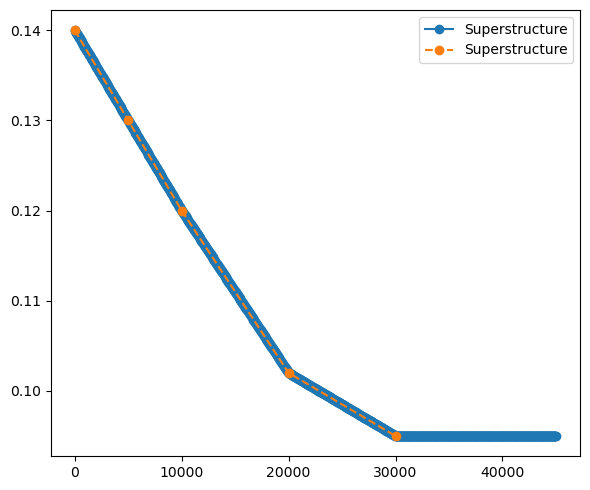

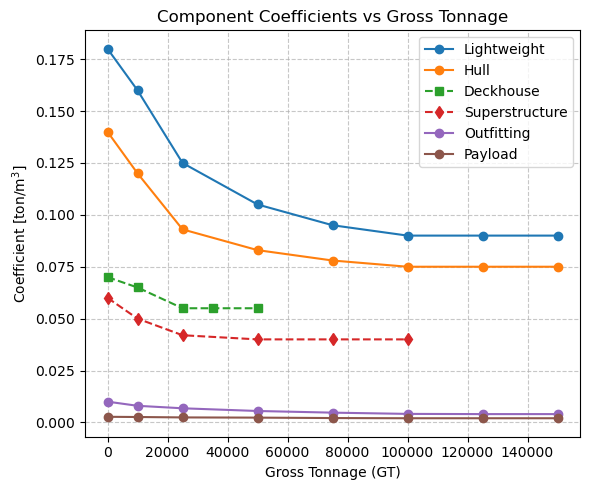

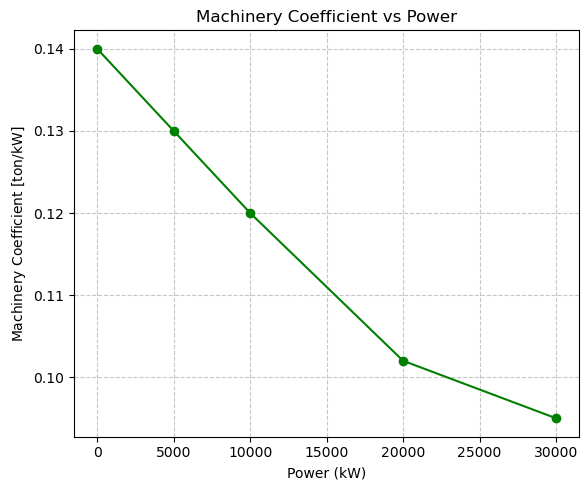

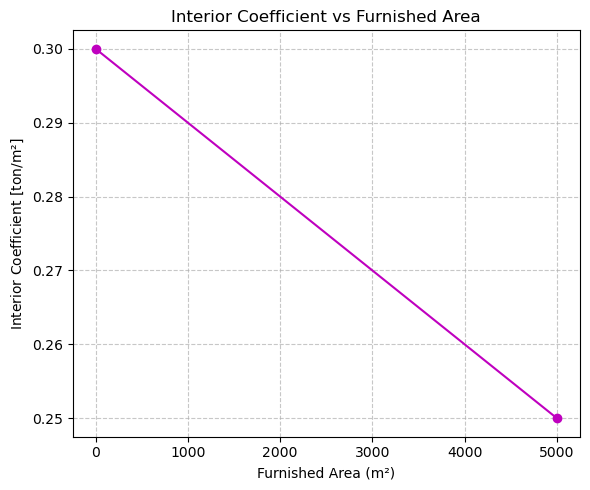

In [ ]:
GT = np.array([0,10000,25000,50000,75000,100000,125000,150000])
lwl = [0.180,0.160,0.125,0.105,0.095,0.09,0.09,0.09]
hull = [0.14,0.12,0.093,0.083,0.078,0.075,0.075,0.075]
outfiting = [0.01,0.008,0.0068,0.0055,0.0047,0.0041,0.004,0.004]
payload = [0.0027,0.0026,0.0024,0.0023,0.0021,0.002,0.002,0.002]

GT_deck = np.array([0,10000,25000,35000,50000])
deckhouse = [0.07,0.065,0.055,0.055,0.055]

GT_super = np.array([0,10000,25000,50000,75000,100000])
superstructure = [0.06,0.05,0.042,0.04,0.04,0.04]

power = [0,5000,10000,20000,30000]
machinery = np.array([0.14,0.13,0.12,0.102,0.095])

fur_area = np.array([0,5000])
interior = [0.3,0.25]

coefficients = {
    'lwl': lwl,
    'hull': hull,
    'outfiting': outfiting,
    'payload': payload,
    'deckhouse': deckhouse,
    'superstructure': superstructure,
    'machinery': machinery,
    'fur_area': interior
}



#GT_values = GT if coef in ['lwl', 'hull', 'outfiting', 'payload'] else (GT_deck if coef == 'deckhouse' else (GT_super if coef == 'superstructure' else (power if coef == 'machinery' else fur_area)))


# Plot 1: GT vs coefficients
#plt.figure(figsize=(10, 6))

gt_test = np.linspace(0, 45000, 1000)

mac_test = []
for i in gt_test:
    mac_test.append(get_weight_coeff('machinery', i))
"""
plt.figure(figsize=(6, 5))
plt.plot(gt_test,mac_test, 'o-', label='Superstructure')
plt.plot(power, machinery, 'o--', label='Superstructure')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(GT, lwl, 'o-', label='Lightweight')
plt.plot(GT, hull, 'o-', label='Hull')
plt.plot(GT_deck, deckhouse, 's--', label='Deckhouse')
plt.plot(GT_super, superstructure, 'd--', label='Superstructure')
#plt.plot(15000,get_weight_coeff('lwl', 15000), color='red', marker='x' ,label='lwl')
plt.plot(GT, outfiting, 'o-', label='Outfitting')
plt.plot(GT, payload, 'o-', label='Payload')

plt.xlabel('Gross Tonnage (GT)')
plt.ylabel(f'Coefficient [ton$/$m$^3$]')
plt.title('Component Coefficients vs Gross Tonnage')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Power vs Machinery Coefficient
plt.figure(figsize=(6, 5))
plt.plot(power, machinery, 'o-g', label='Machinery')
plt.xlabel('Power (kW)')
plt.ylabel('Machinery Coefficient [ton$/$kW]')
plt.title('Machinery Coefficient vs Power')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 3: Furnished Area vs Interior Coefficient
plt.figure(figsize=(6, 5))
plt.plot(fur_area, interior, 'o-m', label='Interior')
plt.xlabel('Furnished Area (m²)')
plt.ylabel('Interior Coefficient [ton$/$m²]')
plt.title('Interior Coefficient vs Furnished Area')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
"""

In [22]:
class MarketMission:
    """
    Holds data about the market analysis and mission requirements.
    E.g., route, cargo type, capacity, speed, regulations, etc.
    """
    def __init__(self, cargo_type, required_capacity, service_speed, range, fuels,df_ship_compare,df_crew):
        self.cargo_type = cargo_type
        self.required_capacity = required_capacity
        self.service_speed = service_speed
        self.range = range
        self.fuels = fuels
        self.df_ship_compare = df_ship_compare
        self.df_crew = df_crew

        
        df = self.df_crew
        cap = self.required_capacity
        x, y, r, re = get_model(df['Gas Capacity'],df['Crew'],'')
        crew_est = get_wanted_values(x, y,[cap])[0]
        self.crew_number = int(round(crew_est))
        self.officer_number = int(self.crew_number * 0.5)
    
    def __repr__(self):
        return (f"MarketMission(cargo_type={self.cargo_type},"
                f"required_capacity={self.required_capacity}, service_speed={self.service_speed})")


In [ ]:
from abc import ABC

class Subsystem(ABC):
    """Base class for all subsystems."""
    def __init__(self, mission : MarketMission):
        self.mission = mission
        # Volume or mass placeholders
        self.area = 0.0
        self.volum = 0.0
        self.weight = 0.0

class CargoSubsystem(Subsystem):
    def __init__(self, mission: MarketMission):
        super().__init__(mission)
        #self.mission =  mission

        self.get_requiered_volume()
    
    def get_requiered_volume(self):
        self.volum = self.mission.required_capacity * 1.5

class Crew_Facilities(Subsystem):
    def __init__(self,  mission: MarketMission):
        super().__init__(mission)
        self.crew_number = mission.crew_number
        self.officer_number = mission.officer_number

        self.get_requiered_volume()

    def get_requiered_volume(self):
        crew_accom = {'Officer. Large': 2*24,
                   'Officer': (self.officer_number-2)*12,
                   'Crew': (self.crew_number-self.officer_number)*12,
                   'Reapir': round(max(int(self.crew_number*0.1),2))*12}
        areal_accom = sum(crew_accom.values())
        volum_accom = areal_accom * 2.8

        crew_comm = {'Officer Mess': self.officer_number * 2,
                     'Officer Dayrom': self.officer_number *2,
                     'Crew Mess' : (self.crew_number - self.officer_number) * 1.8,
                     'Crew Dayrom' : (self.crew_number - self.officer_number) * 1.8,}
        areal_comm = sum(crew_comm.values())
        volum_comm = areal_comm * 2.8
        

        crew_stairs = {'Main stairs' : int(round(np.log10(self.mission.required_capacity**1.3/20))) * 16,
                       'Engine Room stairs' : int(round(np.log10(self.mission.required_capacity**1.4/30)))*15}
        
        areal_stairs = sum(crew_stairs.values())
        volum_stairs = crew_stairs['Engine Room stairs'] * 3.2 + crew_stairs['Main stairs'] *2.8
        
        self.area = areal_accom + areal_comm + areal_stairs
        self.volum = volum_accom + volum_comm + volum_stairs
    

class Service_Facilites(Subsystem):
    def __init__(self, mission: MarketMission):
        super().__init__(mission)
        self.tec_area = 0
        self.tec_volu = 0

        self.get_requiered_volume()


    def get_requiered_volume(self):
        crew = self.mission.crew_number

        ship_ser = {'Wheelhouse' : 4 * crew,
                    'Offices' : 1 * crew,
                    'Sick bay': 1 * crew,
                    'Cargo Handling': 1* crew}
        area_ser = sum(ship_ser.values()) 
        volum_ser = area_ser * 2.8

        catering = {'Gallys' : 1 * crew,
                    'Provison store' : 1.5 * crew,
                    'Garbage' : 0.5 * crew}
        catering_area = sum(catering.values())
        volume_cat = catering['Gallys'] * 3 + catering['Provison store'] * 3 + catering['Garbage'] * 2.8

        hotel_ser = {'Landry' : 1 * crew,
                     'Hotel Store' : 1 * crew}
        hotel_area = sum(hotel_ser.values())
        hotel_volum = hotel_area * 2.8

        self.area = area_ser + catering_area + hotel_area
        self.volum = volum_ser + volume_cat + hotel_volum

        techincal_rooms = {'Air con' : 3 * crew,
                           'Deck stores and workshops' : 1 * crew}
        area_tech = sum(techincal_rooms.values())
        volum_tech = area_tech * 2.8

        self.tec_area = area_tech
        self.tec_volu = volum_tech


class MachinerySubsystem(Subsystem):
    def __init__(self, mission : MarketMission):
        super().__init__(mission)
        self.ins_main_engine_power = 0  # kW
        self.ins_aux_engine_power = 0
        self.ins_tot_engine_power = 0

        self.ser_main_engine_power = 0  # kW
        self.ser_aux_engine_power = 0
        self.ser_tot_engine_power = 0


        self.estiamte_power_req()
        self.get_requiered_volume()
    
    def estiamte_power_req(self):
        cap = self.mission.required_capacity
        df = self.mission.df_ship_compare

        if cap < 5000:
            df_small = df[df['Gas Capacity']<=5000]
            x_s, y_s, r, re = get_model(df_small['Gas Capacity'],df_small['Total KW Main Eng'],'')
            est_power = get_wanted_values(x_s, y_s,[cap])[0]
            self.ins_main_engine_power = est_power

            x_s, y_s, r, re = get_model(df_small['Gas Capacity'],df_small['Aux. Engine Total KW'],'')
            est_aux_power = get_wanted_values(x_s, y_s,[cap])[0]
            self.ins_aux_engine_power = est_aux_power

        else:
            x, y, r, re = get_model(df['Gas Capacity'],df['Total KW Main Eng'],'')
            est_power = get_wanted_values(x, y,[cap])[0]
            self.ins_main_engine_power = est_power

            x, y, r, re = get_model(df['Gas Capacity'],df['Aux. Engine Total KW'],'')
            est_aux_power = get_wanted_values(x, y,[cap])[0]
            self.ins_aux_engine_power = est_aux_power

        self.ins_tot_engine_power = self.ins_aux_engine_power + self.ins_main_engine_power

        self.ser_main_engine_power = self.ins_main_engine_power
        self.ser_aux_engine_power =  self.ins_aux_engine_power
        self.ser_tot_engine_power = self.ser_main_engine_power + self.ser_aux_engine_power
        
    def get_requiered_volume(self):
        power = self.ser_tot_engine_power

        machinery_are = {
            'Steering gear' : 0.004 * power,
            'Bow thruster' : 0.002 * power,
            'Switchboard rooms' : 0.02 * power,
            'Workshops and stores' : 0.003 * power,
            'Emergency gen.' : 0.001 * power}
        
        mac_area = sum(machinery_are.values())
        mac_volu = (mac_area - 0.001 * power) * 3.2 + 0.001 * power * 2.8
        

        machinery_vol = {
            'Engine and Pump Rooms' : 0.4 * power}
        mac_volu += machinery_vol['Engine and Pump Rooms']

        self.volum = mac_volu

    def update_power(self,new_power):
        self.ser_main_engine_power = new_power
        self.ser_tot_engine_power = self.ser_main_engine_power + self.ser_aux_engine_power
        self.get_requiered_volume()
    
        
class TanksSubsystem(Subsystem):
    def __init__(self, mission : MarketMission, machinery: MachinerySubsystem, bw_side = 0, bw_bottom = 0, voids = 0):
        super().__init__(mission)
        self.machinery = machinery

        self.bw_side = bw_side
        self.bw_bottom = bw_bottom
        self.voids = voids

        self.get_requied_volume_sail()
    
    def get_requied_volume_sail(self):
        power = self.machinery.ser_tot_engine_power
        fuels = self.mission.fuels
        
        range = self.mission.range
        speed = self.mission.service_speed
        crew = self.mission.crew_number

        self.consum_day = np.array([value[0] * power / 1e6 * 24 for value in fuels.values()])
        self.endure_day = range / speed / 24

        self.weight = [value[1] * self.endure_day * self.consum_day[i] for i, value in enumerate(fuels.values())]
        volume = [self.weight[i] / value[2] for i, value in enumerate(fuels.values())]

        self.sewage = 0.075 * crew * self.endure_day * 0.2
        self.fresh_water = 0.2 * crew * self.endure_day * 1.2

        self.volum = sum(volume) + self.fresh_water + self.sewage + self.bw_side + self.bw_bottom + self.voids


class Ship():
    def __init__(self, mission : MarketMission, cargo : CargoSubsystem, crew: Crew_Facilities, ser : Service_Facilites, mac : MachinerySubsystem, tan : TanksSubsystem, fuel = 'Diesel'):
        self.mission = mission
        self.cargo = cargo
        self.crew = crew
        self.ser = ser
        self.mac = mac
        self.tan = tan

        self.GV = 0
        self.GT = 0
        self.fuel = fuel

        self.get_system_sumary()
        self.get_weight()
        self.get_bulding_cost()

    def get_system_sumary(self):
        
        self.cargo_spaces_vol = self.cargo.volum

        self.total_furnis_vol = self.crew.volum + self.ser.volum
        self.total_interi_vol = self.total_furnis_vol + self.ser.tec_volu

        self.total_tecnic_vol = self.mac.volum
        self.total_tanks_vol = self.tan.volum
        
        self.system_sum = {'Cargo Spaces': self.cargo_spaces_vol,
                      'Total furnished spaces' : self.total_furnis_vol,
                      'Total interior spaces' : self.total_interi_vol,
                      'Total technical spaces' : self.total_tecnic_vol,
                      'Tanks and voids' : self.total_tanks_vol}
        
        self.GV = sum(self.system_sum.values())-self.total_furnis_vol
        self.GT = (0.2 + 0.02 * np.log10(self.GV)) * self.GV

        self.total_interior_area = self.crew.area + self.ser.area
        self.hull_volume = self.cargo_spaces_vol + self.total_tecnic_vol + self.total_tanks_vol
        self.deckhouse_volume = self.total_interi_vol
    
    def get_weight(self):
        self.lightweight = {'Task Related Systems': self.GV * get_weight_coeff('payload',self.GT),
                            'Hull Structure' : self.hull_volume * get_weight_coeff('hull',self.GT),
                            'Deck House Structure' : self.deckhouse_volume * get_weight_coeff('deckhouse', self.GT),
                            'Interior Outfiting' : self.total_interior_area * get_weight_coeff('fur_area',self.total_interior_area),
                            'Machinery Outfiting' : self.mac.ins_tot_engine_power * get_weight_coeff('machinery',self.mac.ins_tot_engine_power),
                            'Ship Outfiting' : self.GV * get_weight_coeff('outfiting',self.GV)}
        
        self.total_lightweight = sum(self.lightweight.values())

        self.deadweight = {'Tank Cargo' : self.mission.required_capacity * 0.68,
                           'Persons aboard' : self.mission.crew_number *0.1,
                           'Provisions and stores' : self.mission.crew_number * 0.1,
                           'Fuel amount' : sum(self.tan.weight[:-1]) * 2.4,
                           'Lub oil' : self.tan.weight[-1] * 5,
                           'Fresh water' : self.tan.fresh_water * 2.4,
                           'Sewage' : self.tan.sewage * 1.2,
                           'Ballast water' : 0,
                           'Slop tanks' : 0,
                           'Misc' : 0}
        
        self.total_deadweight = sum(self.deadweight.values())

        self.displacment = self.total_lightweight + self.total_deadweight

    def get_transverse_center_of_gravity(self, D):
        self.lightweight_moment = {
            'Task realted systems': 0.6 * D * self.lightweight['Task Related Systems'],
            'Hull Structure': 0.6 * D * self.lightweight['Hull Structure'],
            'Deck House Structure': 1.3 * D * self.lightweight['Deck House Structure'],
            'Interior Outfiting': 1.25 * D * self.lightweight['Interior Outfiting'],
            'Machinery Outfiting': 0.4 * D * self.lightweight['Machinery Outfiting'],
            'Ship Outfiting': 1 * D * self.lightweight['Ship Outfiting']
        }

        self.lightweight_KG = sum(self.lightweight_moment.values()) / self.total_lightweight

        self.deadweight_moment = {
            'Tank Cargo': 0.6 * D * self.deadweight['Tank Cargo'],
            'Persons aboard': 1.3 * D * self.deadweight['Persons aboard'],
            'Provisions and stores': 1.05 * D * self.deadweight['Provisions and stores'],
            'Fuel amount': 0.4 * D * self.deadweight['Fuel amount'],
            'Lub oil': 0.5 * D * self.deadweight['Lub oil'],
            'Fresh water': 0.4 * D * self.deadweight['Fresh water'],
            'Sewage': 0.05 * D * self.deadweight['Sewage'],
            'Ballast water': 0.5 * D * self.deadweight['Ballast water'],
            'Slop tanks': 0.0 * D * self.deadweight['Slop tanks'],
        }

        self.deadweight_KG = sum(self.deadweight_moment.values()) / self.total_deadweight

        self.total_moment = sum(self.deadweight_moment.values()) + sum(self.lightweight_moment.values())
        self.KG = self.total_moment/self.displacment
    
    def get_bulding_cost(self, reserve=0.05, intrest = 0.06,buling_time=18, profit = 0.05, finacing_pay = 0.03, broke_fee = 0.01):
        self.material_cost = {
            'General' : self.total_lightweight * 2000,
            'Task Related Systems': self.cargo_spaces_vol * 5000,
            'Hull Structure' : self.lightweight['Hull Structure'] * 8000,
            'Deck House Structure' : self.lightweight['Deck House Structure'] * 8000,
            'Interior Outfiting' : self.lightweight['Interior Outfiting']* 15000,
            'Machinery Outfiting' : self.mac.ins_tot_engine_power * 2500 if self.fuel == 'Diesel' else self.mac.ins_tot_engine_power * 3200,
            'Ship Outfiting' : self.GV * 100
            }

        self.labour_hours = {
            'General' : self.total_lightweight * 5,
            'Task Related Systems': self.cargo_spaces_vol * 10,
            'Hull Structure' : self.lightweight['Hull Structure'] * 30,
            'Deck House Structure' : self.lightweight['Deck House Structure'] * 50,
            'Interior Outfiting' : self.lightweight['Interior Outfiting']* 25,
            'Machinery Outfiting' : self.mac.ins_tot_engine_power * 2,
            'Ship Outfiting' : self.GV * 2
            }

        
        self.sum_material_cost = sum(self.material_cost.values())
        self.sum_labour = sum(self.labour_hours.values())

        self.sum_material_cost_res = self.sum_material_cost * (1+reserve)
        self.sum_labour_res = self.sum_labour * (1+reserve)

        self.design_cost = 10 * self.total_lightweight * 400
        self.labor_cost = self.sum_labour_res * 500
        self.bulding_time_fin = buling_time * (100 *intrest)/4
        self.total_production_cost = self.design_cost + self.labor_cost + self.bulding_time_fin

        self.profit = self.total_production_cost * profit
        self.fin_pay = self.total_production_cost * finacing_pay
        self.brok_fee = self.total_production_cost * broke_fee

        self.bulding_cost = self.total_production_cost + self.profit + self.fin_pay + self.brok_fee

    def update_power(self,new_power,d):
        self.mac.update_power(new_power)
        self.tan.get_requied_volume_sail()
        self.get_system_sumary()
        self.get_weight()
        self.get_transverse_center_of_gravity(d)
        self.get_bulding_cost()
        
        

NameError: name 'MarketMission' is not defined

In [24]:
def get_Ship(name,cap,speed,range,fuels,df_comp,df_crew,bw_side = 0, bw_bottom = 0, void = 0, fuel = 'Diesel'):
    mis = MarketMission(name, cap, speed, range, fuels, df_comp, df_crew) 

    car = CargoSubsystem(mis)
    lug = Crew_Facilities(mis)
    serv = Service_Facilites(mis)
    mas = MachinerySubsystem(mis)
    tanks = TanksSubsystem(mis,mas,bw_side,bw_bottom,void)
    vessel = Ship(mis,car,lug,serv,mas,tanks,fuel)
    
    if bw_bottom + bw_side + void == 0:
        gv = vessel.GV
        tanks = TanksSubsystem(mis,mas,car.volum*0.12,car.volum*0.16,gv*0.03)

    vessel = Ship(mis,car,lug,serv,mas,tanks)
    return vessel

In [ ]:
def get_feasibility_dim(df_gen, df_data):
    df_data['L/B'] = df_data['Length BP'] / df_data['Breadth']
    df_data['B/D'] = df_data['Breadth'] / df_data['Draught']
    lb_min, lb_max = df_data['L/B'].min(), df_data['L/B'].max()
    bd_min, bd_max = df_data['B/D'].min(), df_data['B/D'].max()

    df_gen['Lpp/B'] = df_gen['Lpp'] / df_gen['B']
    df_gen['B/D'] = df_gen['B'] / df_gen['T']
    
    # Guldhammer-Harvald constraints
    L_B_min, L_B_max = 5.0, 8.0
    L3_min, L3_max = 4.0, 6.0
    Fn_max_gul = 0.33
    CB_min, CB_max = 0.55, 0.85

    # Compute additional parameters
    df_gen['L/Vol^(1/3)'] = df_gen['Lpp'] / (df_gen['Volum_disp']**(1/3))

    # Apply filtering
    df_gen = df_gen[
        (df_gen['Lpp/B'] >= lb_min) & (df_gen['Lpp/B'] <= lb_max) &
        (df_gen['B/D'] >= bd_min) & (df_gen['B/D'] <= bd_max) &
        (df_gen['Lpp/B'] >= L_B_min) & (df_gen['Lpp/B'] <= L_B_max)
    ]
    
    if 'L/Vol^(1/3)' in df_gen.columns:
        df_gen = df_gen[(df_gen['L/Vol^(1/3)'] >= L3_min) & (df_gen['L/Vol^(1/3)'] <= L3_max)]
    if 'Fn' in df_gen.columns:
        df_gen = df_gen[df_gen['Fn'] <= Fn_max_gul]
    if 'Cb' in df_gen.columns:
        df_gen = df_gen[(df_gen['Cb'] >= CB_min) & (df_gen['Cb'] <= CB_max)]
    
    # Remove temporary columns before returning
    df_gen = df_gen.drop(columns=['Lpp/B', 'B/D','L/Vol^(1/3)'], errors='ignore')

    return df_gen


In [ ]:
def generate_hulls(Ls = 40, Bs = 40, Ts = 20, Cbs = 10):
    Lpp = np.linspace(30,250,Ls)#get_int_list(50,100)
    B = np.linspace(1,50,Bs)#get_int_list(1,20)
    T = np.linspace(1,30,Ts)#get_int_list(1,15)
    Speeds = get_int_list(10,20)
    Speeds = np.array([12, 13.5 ,15, 18, 20, 22, 25])
    #Cb = np.linspace(0.55,0.85,Cbs)

    #Ships = np.array(np.meshgrid(Lpp,B,T,Speeds,Cb)).T.reshape(-1,5)
    Ships = np.array(np.meshgrid(Lpp,B,T,Speeds)).T.reshape(-1,4)
    df = pd.DataFrame(Ships)
    df.rename(columns={0:'Lpp', 1:'B', 2:'T', 3:'Speed', 4: 'Cb'}, inplace=True)
    df.rename(columns={0:'Lpp', 1:'B', 2:'T', 3:'Speed'}, inplace=True)

    
    

    df['Lwl'] = df['Lpp'] * 1.02
    df['Fn'] = df['Speed']*0.5144/(np.sqrt(9.81*1.03*df['Lpp']))
    df['Cb'] = df.apply(lambda row: get_hull_coff('Cb',row['Fn']), axis=1)
    df['Dp'] = 0.395 * df['T'] + 1.3  
    
    df['Volum_disp'] = df['Lpp'] * df['B'] * df['T'] * df['Cb']
    df['Weigh_disp'] = df['Volum_disp'] * 1.025
    df = get_feasibility_dim(df,df_ship_compare)
    
    df['Cm']= df.apply(lambda row: get_hull_coff('Cm',row['Fn']), axis=1)

    df['Cw'] = df['Cb']**0.4
    df['Cp'] = df['Cb'] / df['Cm']
    df['Cpv'] = df['Cb']/df['Cw']

    df['KB'] = df['T'] * ((5/6) - (1/3) *(df['Cb']/(df['Cw'])))
    df['BM'] = (0.0372 * (2 * df['Cw'] + 1)**3 * df['Lpp'] * df['B']**3 *1/12)/ df['Volum_disp']
    df['KM'] = df['KB'] + df['BM']
    
    df['Deck Area'] = df['Cw'] * df['Lpp'] * df['B']
    df['Wet surface'] = 0.99 * (df['Volum_disp']/df['T']+ 1.9 * df['Lwl'] * df['T'])



    df['RT'], df['w'], df['t'], df['eta'] = zip(*df.apply(lambda row: guldhammer(row['Lpp'], row['B'], row['T'], row['Cb'], row['Volum_disp'], row['Speed'],row['Cw']), axis=1))
    df['RT'] = df['RT'] / 1e3
    df['Pe'] = df['RT'] * df['Speed'] * 0.5144/( df['eta'] * 0.6 ) * 1.25/0.85
    df = df[(df['Pe'] < 2e5) & (df['Pe'] > 0)]
    df['Dobbel Bottom Height'] = np.maximum(0.760, np.minimum(2, 1 * df['B'] / 20))

    return df.reset_index(drop=True)
    

freeboard_table = pd.read_excel("Freeboard table.xlsx").dropna()   
def get_freeboard(L, T, cb=0, df=freeboard_table):
    D = T / 0.85
    F = D - T
    table_value = np.interp(L, df['Length of Ship'], df['Freeboard increase']) / 1000
    if cb > 0.68:
        table_value = (cb + 0.68) / 1.36 * table_value
    return round(D + table_value, 3)



# Hull generation

In [26]:
# Manually digitized data from Figure 4.13.2 (approximate)
data_curves = {
    0.50: [
        (0.0, 0.00), (0.1, 0.20), (0.2, 0.50), (0.3, 0.78), (0.4, 0.89),
        (0.5, 0.87), (0.6, 0.75), (0.7, 0.55), (0.8, 0.30), (0.9, 0.10), (1.0, 0.07), (1.02, 0.03)
    ],
    0.60: [
        (0.0, 0.00), (0.1, 0.25), (0.2, 0.60), (0.3, 0.87), (0.4, 0.97),
        (0.5, 0.97), (0.6, 0.89), (0.7, 0.72), (0.8, 0.48), (0.9, 0.20), (1.0, 0.09), (1.02, 0.04)
    ],
    0.70: [
        (0.0, 0.00), (0.1, 0.30), (0.2, 0.70), (0.3, 0.93), (0.4, 0.98),
        (0.5, 0.98), (0.6, 0.98), (0.7, 0.91), (0.8, 0.70), (0.9, 0.39), (1.0, 0.09), (1.02, 0.04)
    ],
    0.80: [
        (0.0, 0.00), (0.1, 0.40), (0.2, 0.83), (0.3, 0.96), (0.4, 0.99),
        (0.5, 0.999), (0.6, 0.999), (0.7, 0.999), (0.8, 0.96), (0.9, 0.70), (1.0, 0.10), (1.02, 0.04)
    ],
    0.85: [
        (0.0, 0.00), (0.1, 0.55), (0.2, 0.90), (0.3, 0.98), (0.4, 0.999),
        (0.5, 0.999), (0.6, 0.999), (0.7, 0.999), (0.8, 0.99), (0.9, 0.90), (1.0, 0.10), (1.02, 0.04)
    ]
}

def interp_in_x(xy_pairs, x):
    """
    Piecewise linear interpolation in the x-dimension for a single CB curve.
    xy_pairs is a sorted list of (x_i, y_i).
    """
    # Clamp x if outside the data range
    if x <= xy_pairs[0][0]:
        return xy_pairs[0][1]
    if x >= xy_pairs[-1][0]:
        return xy_pairs[-1][1]
    
    # Find the interval where x lies
    for i in range(len(xy_pairs) - 1):
        x1, y1 = xy_pairs[i]
        x2, y2 = xy_pairs[i+1]
        if x1 <= x <= x2:
            # Linear interpolation
            if abs(x2 - x1) < 1e-9:  # avoid division by zero
                return y1
            frac = (x - x1) / (x2 - x1)
            return (1 - frac)*y1 + frac*y2
    
    return 0.0  # fallback, should not happen if data is well-formed

def area_ratio(cb, x):
    """
    Returns A(x)/(B*T) for a *continuous* cb in [0.50..0.85] and x in [0..1].
    Uses piecewise linear interpolation in both CB and x.
    """
    # Sort the known CB keys
    cb_keys = sorted(data_curves.keys())  # [0.50, 0.60, 0.70, 0.80, 0.85]
    
    # Clamp cb to [min..max]
    if cb < cb_keys[0]:
        cb = cb_keys[0]
    if cb > cb_keys[-1]:
        cb = cb_keys[-1]
    
    # If cb is exactly one of the keys, just interpolate in x and return
    if cb in data_curves:
        return interp_in_x(data_curves[cb], x)
    
    # Otherwise, find the two bounding CBs
    for i in range(len(cb_keys) - 1):
        cb_low = cb_keys[i]
        cb_high = cb_keys[i+1]
        if cb_low <= cb <= cb_high:
            # Interpolate in x for each bounding CB
            val_low = interp_in_x(data_curves[cb_low], x)
            val_high = interp_in_x(data_curves[cb_high], x)
            # Now interpolate those two results in CB dimension
            f = (cb - cb_low) / (cb_high - cb_low)
            return (1 - f)*val_low + f*val_high
    
    # Fallback (should not happen)
    return 0.0

In [ ]:
def get_station(x, Cb,B, T,round=0.9,points = 10, freeboard = 0):
    """Generates cross-sectional profile at a given x-location."""
    Cm = area_ratio(Cb, x)  # Compute area coefficient variation
    Am = B * T * Cm  # Sectional area

    def area_difference(t):
        """Function to find the correct exponent t that satisfies the area."""
        eps = 1e-6  
        xs = np.linspace(0, B, 1000)
        ys = (np.abs(np.sin(xs * np.pi / (B)))) ** t * T + eps
        area = np.trapz(ys, xs)  
        return area - Am  
    
    fa = area_difference(0.00001)
    fb = area_difference(100)

    #print(f"Area difference: {fa:.2f} - {fb:.2f}")

    if fa * fb > 0:
        print(f"Area mismatch at x={x:.2f}, Cm={Cm:.3f}. Area bounds: [{fa:.2f}, {fb:.2f}]")
        return np.zeros(points * 2), np.zeros(points * 2)

    try:
        # Try solving normally
        t_solution = brentq(area_difference, 0.00001, 100)
    except ValueError as e:
        print(f"Brentq failed at x={x:.2f}, Cb={Cb:.3f}, B={B:.2f}, T={T:.2f}: {e}")
        # Return flat section instead of crashing
        ys = np.linspace(-B/2, B/2, points * 2)
        zs = np.full_like(ys, T)
        return ys, zs

    if t_solution < 1 or x < round:
        ys = np.linspace(0, B/2, points)
        zs = (np.sin(ys * np.pi / B) ) ** t_solution * T
        zs = np.concatenate((zs,np.flip(zs)))
        ys = np.concatenate((ys,np.linspace(B/2,B,points)))
        ys -= B/2
        zs = T - zs
    else:
        def area_difference(t):
            xs = np.linspace(0, 1/t*np.log(T+1), 100)
            height = np.linspace(T, T, 100)
            ys = np.exp(xs * t) - 1# + 2/5 * T 
            area_under = np.trapz(ys, xs) 
            area_whole = np.trapz(height, xs)
            area = area_whole - area_under
            return area - Am/2  # Difference from target
        
        # Add bounds check
        fa = area_difference(0.01)
        fb = area_difference(2)

        if fa * fb > 0:
            print(f"Rear station mismatch at x={x:.2f}, Cm={Cm:.3f}. Area bounds: [{fa:.2f}, {fb:.2f}]")
            ys = np.linspace(-B / 2, B / 2, points * 2)
            zs = np.full_like(ys, T)
            return ys, zs
        


        t_solution = brentq(area_difference, 0.01, 2, maxiter=1000)  # Ensuring positive t


        cross = 1/t_solution*np.log(T + 1) #-2/5 * T)

        ys = np.linspace(0, cross, points)
        zs = (np.exp(ys * t_solution) - 1)

        ys = np.linspace(0, cross/2, points)
        zs = np.concatenate((zs,np.flip(zs)))
        ys = np.concatenate((ys,np.linspace(cross/2,cross,points)))
        ys -= cross/2
        zs = T - zs 
    
    
    ys = np.insert(ys,0,ys[0])
    zs = np.insert(zs,0,max(zs)+freeboard)


    ys = np.append(ys,ys[-1])
    zs = np.append(zs,max(zs))
    return ys , zs

In [28]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull

def calculate_volume_from_poly3d(verts):
    """
    Computes the enclosed volume of a 3D shape using ConvexHull.
    
    Parameters:
    - verts: List of 3D coordinate arrays representing the ship's hull structure
    
    Returns:
    - Enclosed volume (cubic meters)
    """
    # Flatten all vertices into a single list of points
    points = np.vstack(verts)

    # Find the highest Z-value (to avoid computing open space above the hull)
    #max_z = np.max(points[:, 2])

    # Filter points to remove those above the hull
    #points = points[points[:, 2] <= max_z]

    # Create the convex hull
    hull = ConvexHull(points)

    # Return the computed volume
    return hull.volume


def get_hull_volume(B, T, L, Cb, freeboard=0, s=10, points=7, start=0.05, end=0.98):
    x_positions = np.linspace(start * L, end * L, s)
    verts = []

    for x in x_positions:
        ys, zs = get_station(x / L, Cb, B, T, round=0.9, points=points, freeboard=freeboard)
        xs = np.full_like(ys, x)
        verts.append(np.column_stack([xs,ys, zs]))
    
    volume = calculate_volume_from_poly3d(verts)
    return volume



In [ ]:
def calculate_outward_wetted_surface(verts, draft):
    """
    Estimates the wetted surface area of the hull below the waterline (draft),
    assuming symmetry and only counting one side (e.g., starboard).
    """
    wetted_surface = 0.0
    
    for i in range(len(verts) - 1):
        sec1 = verts[i]
        sec2 = verts[i + 1]
        
        # Only use half of the section (starboard side)
        mid_index = len(sec1) // 2
        for j in range(mid_index):
            # Define two triangular faces per panel
            tri1 = [sec1[j], sec1[j + 1], sec2[j + 1]]
            tri2 = [sec1[j], sec2[j + 1], sec2[j]]
            
            for tri in [tri1, tri2]:
                z_avg = np.mean([p[2] for p in tri])
                if z_avg <= draft:  # Only count panels below waterline
                    a = np.linalg.norm(tri[0] - tri[1])
                    b = np.linalg.norm(tri[1] - tri[2])
                    c = np.linalg.norm(tri[2] - tri[0])
                    s = 0.5 * (a + b + c)
                    A = np.sqrt(max(s * (s - a) * (s - b) * (s - c), 0))
                    wetted_surface += A
    
    # Multiply by 2 to account for symmetry (if you want total wetted surface)
    return wetted_surface *2


In [ ]:
def plot_hull_with_tanks(B, T, L, Cb, tanks=[], freeboard=0, s=10, points=7, start=0.05, end=0.98):
    %matplotlib widget
    x_positions = np.linspace(start * L, end * L, s)
    verts = []

    for x in x_positions:
        ys, zs = get_station(x / L, Cb, B, T, round=0.9, points=points, freeboard=freeboard)
        xs = np.full_like(ys, x)
        verts.append(np.column_stack([xs,ys,zs]))
    
    fig = plt.figure(figsize=(18, 14))
    ax = fig.add_subplot(111, projection='3d')
    
    for i in range(len(verts) - 1):
        faces = []
        for j in range(len(verts[i]) - 1):
            faces.append([verts[i][j], verts[i][j + 1], verts[i + 1][j + 1], verts[i + 1][j]])
        poly = Poly3DCollection(faces, alpha=0.6, edgecolor='k', facecolor='cyan')
        ax.add_collection3d(poly)

    volume = calculate_volume_from_poly3d(verts)
    surcafe = calculate_outward_wetted_surface(verts, T)
    print(f"Estimated Enclosed Volume: {volume:.2f} cubic meters\nEstimated Wetted Surface Area: {surcafe:.2f} square meters")
    
    ax.set_box_aspect([L/L, B/L, (T+freeboard)/L])
    ax.set_xlabel("Length (L)")
    ax.set_ylabel("Beam (B)")
    ax.set_zlabel("Draft (T)")
    ax.set_xlim(0, L)
    ax.set_ylim(-B/2, B/2)
    ax.set_zlim(0, T + freeboard)
    ax.view_init(elev=20, azim=-60)  # Adjusted for better visualization
    
    for tank in tanks:
        if isinstance(tank, BilobeTank):
            X, Y1, Z1, Y2, Z2, X_front, Y_front1, Z_front1, Y_front2, Z_front2, X_back, Y_back1, Z_back1, Y_back2, Z_back2 = tank.generate_tank_mesh()
            ax.plot_surface(X, Y1, Z1, color='red', edgecolor='k', alpha=0.7)
            ax.plot_surface(X, Y2, Z2, color='red', edgecolor='k', alpha=0.7)
            ax.plot_surface(X_front, Y_front1, Z_front1, color='red', edgecolor='k', alpha=0.7)
            ax.plot_surface(X_front, Y_front2, Z_front2, color='red', edgecolor='k', alpha=0.7)
            ax.plot_surface(X_back, Y_back1, Z_back1, color='red', edgecolor='k', alpha=0.7)
            ax.plot_surface(X_back, Y_back2, Z_back2, color='red', edgecolor='k', alpha=0.7)
        else:
            X, Y, Z, X_front, Y_front, Z_front, X_back, Y_back, Z_back = tank.generate_tank_mesh()
            ax.plot_surface(X, Y, Z, color='red', edgecolor='k', alpha=0.7)
            ax.plot_surface(X_front, Y_front, Z_front, color='red', edgecolor='k', alpha=0.7)
            ax.plot_surface(X_back, Y_back, Z_back, color='red', edgecolor='k', alpha=0.7)
    #compute_distances_for_tanks_using_surfaces(verts,tanks)
    

    plt.tight_layout()    
    plt.show()
    %matplotlib inline
#plot_hull_with_tanks(29,9.8,150,0.79)

In [ ]:
def get_hull_volume_surface(L , B, T, Cb, freeboard=0, s=10, points=10, start=0.05, end=0.98):
    x_positions = np.linspace(start * L, end * L, s)
    verts = []

    for x in x_positions:
        ys, zs = get_station(x / L, Cb, B, T, round=0.9, points=points, freeboard=freeboard)
        xs = np.full_like(ys, x)
        verts.append(np.column_stack([xs,ys, zs]))
    
    
    volume = calculate_volume_from_poly3d(verts)
    surface = calculate_outward_wetted_surface(verts, T)
    #print(f"Estimated Enclosed Volume: {volume:.2f} cubic meters\nEstimated Wetted Surface Area: {surface:.2f} square meters")
    print(L,B,T,Cb,freeboard)
    return volume, surface
    
#get_hull_volume_surface(155,29,12,0.67)[1]


155 29 12 0.67 0


6215.9948868155725

In [32]:
plt.show()

# Tanks

In [33]:
from abc import ABC, abstractmethod
class Tank(ABC):
    def __init__(self, vessel):
        self.vessel = vessel
        self.volume = None

    @abstractmethod
    def calculate_volume(self):
        """Method to calculate the volume of the tank. Must be implemented by subclasses."""
        pass

    def calculate_protective_distance(self):
        """Calculates the protective distance d based on the gross design volume Vc."""
        Vc = self.volume  # Assuming volume is calculated first
        if Vc <= 1000:
            self.d = 0.8
        elif 1000 < Vc < 5000:
            self.d = 0.75 + (Vc * 0.2 / 4000)
        elif 5000 <= Vc < 30000:
            self.d = 0.8 + (Vc / 25000)
        else:
            self.d = 2.0
        return self.d



class TransCylindricalTank(Tank):
    def __init__(self, vessel, R, length, position, dome_height=0):
        super().__init__(vessel)
        self.R = R
        self.length = length
        self.position = np.array(position)
        if dome_height == 0:
            self.dome_height = R/2
        else:
            self.dome_height = dome_height
        self.calculate_volume()
        self.calculate_protective_distance()

    def calculate_volume(self):
        self.volume = np.pi * np.square(self.R) * self.length + 4/3 * np.pi * np.square(self.R) * self.dome_height

    def generate_tank_mesh(self, resolution=20):
        theta = np.linspace(0, 2 * np.pi, resolution)
        L_tank = np.linspace(-self.length / 2, self.length / 2, resolution)
        Theta, L_mesh = np.meshgrid(theta, L_tank)
        X = self.R * np.cos(Theta) + self.position[0]
        Y = L_mesh + self.position[1]
        Z = self.R * np.sin(Theta) + self.position[2]

        dome_theta = np.linspace(0, 2 * np.pi, resolution)
        dome_phi = np.linspace(0, np.pi / 2, resolution // 2)
        Dome_Theta, Dome_Phi = np.meshgrid(dome_theta, dome_phi)

        
        X_front = self.R * np.cos(Dome_Theta) * np.cos(Dome_Phi) + self.position[0]
        Y_front = -self.length / 2 + self.dome_height *- np.sin(Dome_Phi)
        Z_front = self.R * np.sin(Dome_Theta) * np.cos(Dome_Phi) + self.position[2]

        X_back = self.R * np.cos(Dome_Theta) * np.cos(Dome_Phi) + self.position[0]
        Y_back = self.length / 2 - self.dome_height * -np.sin(Dome_Phi) 
        Z_back = self.R * np.sin(Dome_Theta) * np.cos(Dome_Phi) + self.position[2]

        return X, Y, Z, X_front, Y_front, Z_front, X_back, Y_back, Z_back

class LongCylindricalTank(Tank):
    def __init__(self, vessel, R, length, position, dome_height=0):
        super().__init__(vessel)
        self.R = R
        self.length = length
        self.position = np.array(position)
        if dome_height == 0:
            self.dome_height = R/2
        else:
            self.dome_height = dome_height
        self.calculate_volume()
        self.calculate_protective_distance()

    def calculate_volume(self):
        self.volume = np.pi * np.square(self.R) * self.length + 4/3 * np.pi * np.square(self.R) * self.dome_height

    def generate_tank_mesh(self, resolution=20):
        theta = np.linspace(0, 2 * np.pi, resolution)
        L_tank = np.linspace(-self.length / 2, self.length / 2, resolution)
        Theta, L_mesh = np.meshgrid(theta, L_tank)
        Y = self.R * np.cos(Theta) + self.position[1]
        X = L_mesh + self.position[0]
        Z = self.R * np.sin(Theta) + self.position[2]

        dome_theta = np.linspace(0, 2 * np.pi, resolution)
        dome_phi = np.linspace(0, np.pi / 2, resolution // 2)
        Dome_Theta, Dome_Phi = np.meshgrid(dome_theta, dome_phi)

        X_front = -self.length / 2 - self.dome_height * np.sin(Dome_Phi) + self.position[0]
        Y_front = self.R * np.cos(Dome_Theta) * np.cos(Dome_Phi) + self.position[1]
        Z_front = self.R * np.sin(Dome_Theta) * np.cos(Dome_Phi) + self.position[2]

        
        X_back = self.length / 2 + self.dome_height * np.sin(Dome_Phi) + self.position[0]
        Y_back = self.R * np.cos(Dome_Theta) * np.cos(Dome_Phi) + self.position[1]
        Z_back = self.R * np.sin(Dome_Theta) * np.cos(Dome_Phi) + self.position[2]

        return X, Y, Z, X_front, Y_front, Z_front, X_back, Y_back,Z_back
    


In [34]:
def extra_area_lobe(R, D):
    R_sq = np.square(R)
    return R_sq * np.pi - 0.5 * D * np.sqrt(-np.square(D) + 4 * R_sq) - 2 * R_sq * np.arcsin(0.5 * D / np.sqrt(R_sq))

def area_bilobe(R, D):
    return 2 * np.pi * np.square(R) - extra_area_lobe(R, D)


def volume_bilobe(R, D, L):
    """ Computes total volume based on the bilobe cross-section area. """
    slice_thickness = (L[-1] - L[0]) / (len(L) - 1)  # Uniform slice thickness
    return np.sum(area_bilobe(R, D) * slice_thickness)  # Sum all slices

def compute_D(L, D_initial, L_break, D_final, L_final):
    slope = (D_final - D_initial) / (L_final - L_break)
    return np.piecewise(L, [L < L_break, L >= L_break], [D_initial, lambda L: D_initial + slope * (L - L_break)])

def total_volume_conical_bilobe(R, L ,D_int,r=None, D_fin=None ,L_break=None, slices = 100000):
    if L_break == None:
        L_break = L/2
    if D_fin == None:
        D_fin = D_int
    if r == None:
        r = R/2
    
    Ls = np.linspace(0, L, slices)
    D = compute_D(Ls, D_int, L_break, D_fin, L)
    volume_lenght = volume_bilobe(R, D, Ls)
    return  volume_lenght

In [35]:
class BilobeTank(Tank):
    def __init__(self, vessel, R, length, position, D_initial, L_break=None, D_final=None, dome_height=0):
        super().__init__(vessel)
        self.R = R
        self.length = length
        self.position = np.array(position)
        self.D_initial = D_initial
        
        if L_break is None:
            self.L_break = self.length / 2
        else:
            self.L_break = L_break
        
        if D_final is None:
            self.D_final = D_initial
        else:
            self.D_final = D_final
        self.L_final = self.length
        if dome_height == 0:
            self.dome_height = R/2
        else:
            self.dome_height = dome_height
        self.calculate_volume()
        self.calculate_protective_distance()

    def calculate_volume(self):
        self.volume = total_volume_conical_bilobe(self.R, self.length, self.D_initial, r=self.dome_height, D_fin=self.D_final)

    def compute_D(self, L):
        slope = (self.D_final - self.D_initial) / (self.L_final - self.L_break)
        return np.piecewise(L, [L < self.L_break - self.length / 2, L >= self.L_break - self.length / 2], [self.D_initial, lambda L: self.D_initial + slope * (L - (self.L_break - self.length / 2))])

    def generate_tank_mesh(self, resolution=20):
        L = np.linspace(-self.length / 2, self.length / 2, resolution)
        D = self.compute_D(L)
        theta = np.linspace(0, 2 * np.pi, resolution)
        Theta, L_mesh = np.meshgrid(theta, L)

        X = L_mesh + self.position[0]
        Y1 = self.R * np.cos(Theta) + D[:, np.newaxis] / 2 + self.position[1]
        Z1 = self.R * np.sin(Theta) + self.position[2]

        Y2 = self.R * np.cos(Theta) - D[:, np.newaxis] / 2 + self.position[1]
        Z2 = self.R * np.sin(Theta) + self.position[2]

        dome_theta = np.linspace(0, 2 * np.pi, resolution)
        dome_phi = np.linspace(0, np.pi / 2, resolution // 2)
        Dome_Theta, Dome_Phi = np.meshgrid(dome_theta, dome_phi)

        X_front = -self.length / 2 - self.dome_height * np.sin(Dome_Phi) + self.position[0]
        Y_front1 = self.R * np.cos(Dome_Theta) * np.cos(Dome_Phi) + self.D_initial / 2 + self.position[1]
        Z_front1 = self.R * np.sin(Dome_Theta) * np.cos(Dome_Phi) + self.position[2]

        Y_front2 = self.R * np.cos(Dome_Theta) * np.cos(Dome_Phi) - self.D_initial / 2 + self.position[1]
        Z_front2 = self.R * np.sin(Dome_Theta) * np.cos(Dome_Phi) + self.position[2]

        X_back = self.length / 2 + self.dome_height * np.sin(Dome_Phi) + self.position[0]
        Y_back1 = self.R * np.cos(Dome_Theta) * np.cos(Dome_Phi) + self.D_final / 2 + self.position[1]
        Z_back1 = self.R * np.sin(Dome_Theta) * np.cos(Dome_Phi) + self.position[2]

        Y_back2 = self.R * np.cos(Dome_Theta) * np.cos(Dome_Phi) - self.D_final / 2 + self.position[1]
        Z_back2 = self.R * np.sin(Dome_Theta) * np.cos(Dome_Phi) + self.position[2]

        return X, Y1, Z1, Y2, Z2, X_front, Y_front1, Z_front1, Y_front2, Z_front2, X_back, Y_back1, Z_back1, Y_back2, Z_back2

# Simulation

In [ ]:
AMMONIA_DENSITY_TON_PER_M3 = 0.68

def tons_to_m3(tons):
    return tons / AMMONIA_DENSITY_TON_PER_M3

def m3_to_tons(m3):
    return m3 * AMMONIA_DENSITY_TON_PER_M3


time_log_prod = {}
ammount_fprod = {}

time_log_fa_s = {}
ammount_store = {}

time_log_bu_s = {}
ammount_bunke = {}

time_log_ship = {}
ammount_sship = {}


class Factory:
    def __init__(self, env, fac_id, prod_rate_tph, store_cap_m3, num_pumps, trans_cap_m3ph, pos):
        self.env = env
        self.fac_id = fac_id
        self.prod_rate_tph = prod_rate_tph
        self.store_cap_m3 = store_cap_m3
        self.trans_cap_m3ph = trans_cap_m3ph
        self.pos = pos

        self.storage = si.Container(env, init=self.store_cap_m3 * 0.5, capacity=self.store_cap_m3)
        self.pumps = si.Resource(env, capacity=num_pumps)

        time_log_prod[self.fac_id] = [0]
        ammount_fprod[self.fac_id] = [0]
        time_log_fa_s[self.fac_id] = [0]
        ammount_store[self.fac_id] = [self.storage.level]

        self.action = env.process(self.generate_ammonia())
        self.mon = env.process(self.monitor_storage())


    def generate_ammonia(self):
        while True:
            yield self.env.timeout(10)
            ammonia_tons = self.prod_rate_tph / 6
            ammonia_m3 = tons_to_m3(ammonia_tons)

            time_log_prod[self.fac_id].append(self.env.now)
            ammount_fprod[self.fac_id].append(ammonia_tons)

            yield self.storage.put(ammonia_m3)

    
    def monitor_storage(self):
            while True:
                yield self.env.timeout(60)
                time_log_fa_s[self.fac_id].append(self.env.now)
                ammount_store[self.fac_id].append(m3_to_tons(self.storage.level))


class BunkerStation:
    def __init__(self, env, bunk_id, num_pumps,pos, storage_cap_m3=20000,inital_store=None, arrival_rate_day=3, ammonia_rate=0.05,ammonia_used_ton=200):
        self.env = env
        self.bunk_id = bunk_id
        self.pos = pos
        self.arrival_rate_day = arrival_rate_day
        self.ammonia_rate = ammonia_rate
        self.ammonia_used_ton = ammonia_used_ton

        self.storage_cap_m3 = storage_cap_m3
        self.storage_cap_ton = m3_to_tons(storage_cap_m3)
        self.ammonia_used_m3 = tons_to_m3(ammonia_used_ton)


        
        self.inital_store = self.storage_cap_m3 * 0.5 if inital_store is None else inital_store

        self.storage = si.Container(env, capacity=self.storage_cap_m3, init=self.inital_store)
        self.pumps = si.Resource(env, capacity=num_pumps)


        time_log_bu_s[self.bunk_id] = [0]
        ammount_bunke[self.bunk_id] = [self.storage.level]
        self.failed_deliveries = 0

        self.action = env.process(self.monitor_ammount())
        self.action2 = env.process(self.deliver_fuel())



    def monitor_ammount(self):
        while True:
            yield self.env.timeout(60)
            time_log_bu_s[self.bunk_id].append(self.env.now)
            ammount_bunke[self.bunk_id].append(m3_to_tons(self.storage.level))
    
    def deliver_fuel(self):
        interval_min  = 60
        arrivals_per_min = self.arrival_rate_day / (24*60)  # Convert to minutes

        while True:
            yield self.env.timeout(interval_min)
            ships_arriving = np.random.poisson(arrivals_per_min * interval_min)
            for i in range(ships_arriving):
                is_ammonia = get_yes_no_amm(self.ammonia_rate)
                if is_ammonia ==  1 and self.storage.level >= self.ammonia_used_m3:
                    self.storage.get(self.ammonia_used_m3)
                    #print(f'{self.env.now} Bunker {self.bunk_id} delivered {self.ammonia_used_ton} tons of ammonia. Remaining: {m3_to_tons(self.storage.level):.2f}')
                elif is_ammonia == 1 and self.storage.level < self.ammonia_used_m3:
                    self.failed_deliveries += self.ammonia_used_ton
                    #print(f'[{self.env.now}] Bunker {self.bunk_id} is out of ammonia. Current level: {m3_to_tons(self.storage.level)} tons.')
            


class SimShip:
    def __init__(self, env, ship_id, ship_design: Ship, pump_rate_m3ph, start_pos, factories, bunkers , fuels,inital_store=None):
        self.env = env
        self.ship_id = ship_id
        self.ship_design = ship_design

        # Use transport capacity and speed from the ship design
        self.tran_cap_m3 = ship_design.mission.required_capacity 
        self.speed = ship_design.mission.service_speed
        self.range = ship_design.mission.range

        # Initialize storage container for ammonia
        self.inital_store = 0 if inital_store is None else inital_store
        self.storage = si.Container(env, init=self.tran_cap_m3 * self.inital_store, capacity=self.tran_cap_m3)

        self.pump_rate_m3ph = pump_rate_m3ph
        self.pos = start_pos

        # Operational locations
        self.factories = factories
        self.fac = factories[0]
        self.bunkers  = bunkers 
        self.bunk = bunkers[0]
        self.fuels = fuels

        # Logging setup
        time_log_ship[ship_id] = [0]
        ammount_sship[ship_id] = [self.storage.level]
        self.port_calls = 0

        # Mode and power setup
        self.mode = "sailing"
        self.main_engine_power = ship_design.mac.ser_main_engine_power
        self.aux_engine_power = ship_design.mac.ser_aux_engine_power

        # Fuel/cargo performance tracking
        self.total_fuel_consumed = 0
        self.total_delivered = 0
        self.distance_travelled_nm = 0
        self.eeoi_beneth = []

        self.mode_log = [(0, "sailing")]  # (time, mode)

        # Initialize total fuel burned per type
        all_fuels = set()
        for engine in self.fuels.values():
            all_fuels.update(engine.keys())
        self.fuel_burnt = {fuel: 0 for fuel in all_fuels}

        # Start main ship behavior
        self.action = env.process(self.transport())
        self.check = env.process(self.monitor_ship())



    def monitor_ship(self):
        while True:
            yield self.env.timeout(6)
            time_log_ship[self.ship_id].append(self.env.now)
            ammount_sship[self.ship_id].append((self.storage.level))


    def transport(self):
        while True:
            # Try to select a factory with available ammonia
            selected_fac = self.select_factory()
            while selected_fac is None:
                yield self.env.process(self.waiting(60))
                selected_fac = self.select_factory()

            # Sail to selected factory
            self.set_mode("sailing")
            yield self.env.process(self.sail(selected_fac.pos, self.speed))
            self.fac = selected_fac
            #print(f"[{self.env.now:.2f}] Ship {self.ship_id} arrived at factory {self.fac.fac_id} at pos {self.pos}. Cargo onboard: {m3_to_tons(self.storage.level):.2f} tons")
            yield self.env.process(self.maneuvering())
            self.port_calls += 1
            
            # Load ammonia from factory
            self.set_mode("loading")
            yield self.env.process(self.load_ammonia(self.fac))




            # Select an appropriate bunker **before** sailing
            result = self.select_bunker()
            while result is None:
                yield self.env.process(self.waiting(10))
                result = self.select_bunker()

            if isinstance(result, BunkerStation):
                self.bunk = result
                yield self.env.process(self.maneuvering())
                self.set_mode("sailing")
                yield self.env.process(self.sail(self.bunk.pos, self.speed))

            elif isinstance(result, tuple) and result[0] == 'via_factory':
                via_factory, final_bunker = result[1], result[2]
                #print(f"[{self.env.now:.2f}] Sailing to factory {via_factory.fac_id} as stepping stone to bunker {final_bunker.bunk_id}")
                yield self.env.process(self.maneuvering())
                self.set_mode("sailing")
                yield self.env.process(self.sail(via_factory.pos, self.speed))
                yield self.env.process(self.maneuvering())
                self.port_calls += 1
                if self.storage.level/self.storage.capacity < 0.9:
                    yield self.env.process(self.load_ammonia(via_factory))

                self.set_mode("sailing")
                yield self.env.process(self.sail(final_bunker.pos, self.speed))
                yield self.env.process(self.maneuvering())
                self.bunk = final_bunker


            #print(f"[{self.env.now:.2f}] Ship {self.ship_id} arrived at bunker {self.bunk.bunk_id} at pos {self.pos}. Cargo onboard:{m3_to_tons(self.storage.level):.2f} tons")
            yield self.env.process(self.maneuvering())
            self.port_calls += 1  
            
            # Unload ammonia
            yield self.env.process(self.unload_ammonia())
            yield self.env.process(self.maneuvering())

    def load_ammonia(self, source):
        if self.pos == source.pos:
            temp_trans_m3 = 0
            amount_trans_m3  = source.trans_cap_m3ph/10
            with source.pumps.request() as req:
                yield req
                time = 6
                while self.storage.level < self.tran_cap_m3:
                    better_factory = self.find_better_factory(source)
                    if better_factory:
                        fill_ratio = self.storage.level / self.tran_cap_m3
                        if fill_ratio < 0.9:
                            #print(f"[{self.env.now:.2f}] Ship {self.ship_id} switching from {source.fac_id} to {better_factory.fac_id} for better fill level. Current level: {m3_to_tons(self.storage.level):.2f} tons")
                            yield self.env.process(self.maneuvering())
                            yield self.env.process(self.sail(better_factory.pos, self.speed))
                            yield self.env.process(self.maneuvering())
                            self.set_mode("loading")
                            self.port_calls += 1
                            temp_trans_m3 = 0
                            self.fac = better_factory
                            source = better_factory
                            continue  # re-check with new factory
                        else:
                            #print(f"[{self.env.now:.2f}] Ship {self.ship_id} is nearly full, skipping switch to {better_factory.fac_id}")
                            break

                    yield self.env.timeout(time)

                    self.get_fuel_burn(time)                   
                    if amount_trans_m3  > (self.tran_cap_m3 - self.storage.level):
                        amount_trans_m3 = self.tran_cap_m3 - self.storage.level
                    yield source.storage.get(amount_trans_m3)
                    yield self.storage.put(amount_trans_m3)
                    temp_trans_m3 += amount_trans_m3
            #print(f"[{self.env.now:.2f}] Ship {self.ship_id} loaded up {m3_to_tons(temp_trans_m3):.2f} tons of ammonia from factory {source.fac_id}. Total onboard: {m3_to_tons(self.storage.level):.2f} tons.")

        else:
            #print('Ship not at source')
            yield self.env.process(self.sail(source.pos, self.speed, self.fuel_con[1]))

    def select_factory(self):
        available = [f for f in self.factories if f.storage.level > 0 and self.get_travel_time_min(f.pos, self.speed)[1] < self.range]  # under 200 nm
        if not available:
            #print(f'[{self.env.now:.2f}] Ship {self.ship_id} waiting for factory to be available')
            return None

        # Score factories based on available cargo and distance
        def factory_score(f):
            _ , distance = self.get_travel_time_min(f.pos, self.speed)
            stored = f.storage.level
            cap = f.storage.capacity
            frac = stored / cap 
            return -(frac**2 * 20 - distance * 0.005)
        
        return min(available, key=factory_score)

    def find_better_factory(self, current):
        threshold = 0.35  # how much fuller another factory needs to be (50%)
        current_level = current.storage.level / current.storage.capacity

        candidates = []
        for fac in self.factories:
            if fac == current:
                continue
            fac_level = fac.storage.level / fac.storage.capacity
            _, dist = self.get_travel_time_min(fac.pos, self.speed)
            if ((fac_level - current_level > threshold and dist < 500 and current_level < 0.01) or (fac_level - current_level > 0.95 and dist < 1500 and current_level < 0.05)) and dist < self.range: 
                #print(f"[{self.env.now:.2f}] Ship {self.ship_id} found a better factory: {fac.fac_id} with level {fac_level:.2f} at distance {dist:.2f} nm. Range: {self.range:.2f} nm")
                candidates.append((fac, fac_level, dist))

        if candidates:
            # pick the fullest nearby one
            best = sorted(candidates, key=lambda x: (-x[1], x[2]))[0]
            return best[0]
        return None


    def unload_ammonia(self):
        amount_trans_m3  = self.pump_rate_m3ph  / 10
        time = 6
        transferred_this_bunker_m3  = 0

        while self.storage.level > 0:
            sink = self.bunk  # Always use current self.bunk
            available_space_m3 = sink.storage.capacity - sink.storage.level

            if available_space_m3 < amount_trans_m3:
                if transferred_this_bunker_m3  > 0:
                    None
                new_bunker = self.select_bunker()
                while new_bunker is None:
                    yield self.env.process(self.waiting(10))
                    new_bunker = self.select_bunker()

                if new_bunker != sink:
                    #print(f"[{self.env.now:.2f}] Ship {self.ship_id} transferred {m3_to_tons(transferred_this_bunker_m3) :.2f} tons to {sink.bunk_id} before switching to {new_bunker.bunk_id}. Total onboard: {m3_to_tons(self.storage.level):.2f} tons.")
                    yield self.env.process(self.sail(new_bunker.pos, self.speed))
                    yield self.env.process(self.maneuvering())
                    self.port_calls += 1
                    self.bunk = new_bunker # Update current bunk
                    transferred_this_bunker_m3  = 0  # Reset for new bunker
                elif new_bunker == sink and self.pos == sink.pos:
                    transferred_this_bunker_m3  = 0
                    pass

            # Re-fetch after potential change
            sink = self.bunk
            available_space_m3 = sink.storage.capacity - sink.storage.level
            if available_space_m3 <= 0:
                break

            actual_transfer = min(amount_trans_m3, self.storage.level, available_space_m3)
            self.set_mode("unloading")
            with sink.pumps.request() as req:
                yield req
                yield self.env.timeout(time)
                self.get_fuel_burn(time)

                self.total_delivered += m3_to_tons(actual_transfer)
                yield sink.storage.put(actual_transfer)
                yield self.storage.get(actual_transfer)
                transferred_this_bunker_m3 += m3_to_tons(actual_transfer)
        #print(f"[{self.env.now:.2f}] Ship {self.ship_id} finished unloading at bunker {sink.bunk_id}. Total transferred: {m3_to_tons(transferred_this_bunker_m3):.2f} tons. Remaining onboard: {self.storage.level:.2f} tons.")



    def get_travel_time_min(self, destination,speed, origin =None):
        if origin is None:
            key = (tuple(self.pos), tuple(destination))
            if key in route_cache:
                distance_nm = route_cache[key]
            else:
                try:
                    route = sr.searoute(self.pos, destination, units='naut')
                    distance_nm = route.properties['length']
                    if self.pos == (6.38,59.65) or destination == (6.38,59.65):
                        distance_nm += 25
                    route_cache[key] = distance_nm
                except:
                    distance_nm = np.linalg.norm(np.array(self.pos) - np.array(destination))
                    #print(f"Route not found, using Euclidean distance: {distance_nm} nm")
            
            return (distance_nm / self.speed) * 60 , distance_nm
        else:
            key = (tuple(origin), tuple(destination))
            if key in route_cache:
                distance_nm = route_cache[key]
            else:
                try:
                    route = sr.searoute(origin, destination, units='naut')
                    distance_nm = route.properties['length']
                    if origin == (6.38,59.65) or destination == (6.38,59.65):
                        distance_nm += 25
                    route_cache[key] = distance_nm
                except:
                    distance_nm = np.linalg.norm(np.array(origin) - np.array(destination))
                    #print(f"Route not found, using Euclidean distance: {distance_nm} nm")
            
            return (distance_nm / self.speed) * 60 , distance_nm

    
    def sail(self, des,speed):
        sailing_time, distance_nm = self.get_travel_time_min(des,speed)

        # Simulate in steps for fuel burn accounting
        step_time = sailing_time / 10
        for i in range(10):
            self.set_mode("sailing")
            yield self.env.timeout(step_time)
            self.get_fuel_burn(step_time)
        
        self.distance_travelled_nm += distance_nm
        self.eeoi_beneth.append(distance_nm * m3_to_tons(self.storage.level))
        self.pos = des
        
    
    def get_fuel_burn(self, time_minutes):
        if self.mode == "sailing":
            main_load = 0.8 * self.main_engine_power
            aux_load = 0.8 * self.aux_engine_power
        elif self.mode in ["loading", "unloading","waiting"]:
            main_load = 0
            aux_load = 0.8 * self.aux_engine_power
        elif self.mode == 'maneuvering':
            main_load = 0.3 * self.main_engine_power
            aux_load = 0.8 * self.aux_engine_power
        else:
            main_load = 0
            aux_load = 0

        def to_kg(sfc_g_per_kwh):
            return sfc_g_per_kwh / 1000

        main_fuels = self.fuels.get("Main", {})
        main_burn_kgph = {f: to_kg(sfc) * main_load for f, sfc in main_fuels.items()}

        aux_fuels = self.fuels.get("Aux", {})
        aux_burn_kgph = {f: to_kg(sfc) * aux_load for f, sfc in aux_fuels.items()}

        # Combine and apply time
        for fuel in set(main_burn_kgph) | set(aux_burn_kgph):
            total_hourly = main_burn_kgph.get(fuel, 0) + aux_burn_kgph.get(fuel, 0)
            total_burn = total_hourly * (time_minutes / 60)
            self.fuel_burnt[fuel] += total_burn

        return
    

    

        

    def select_bunker(self):
        # Primary: bunkers under 35% full and directly reachable
        available = [
            b for b in self.bunkers
            if (b.storage.level / b.storage.capacity) < 0.35
            and self.get_travel_time_min(b.pos, self.speed)[1] < self.range
        ]

        if available:
            def bunker_score(b):
                free_frac = b.storage.level / b.storage.capacity
                _, distance = self.get_travel_time_min(b.pos, self.speed)
                return ((free_frac * 30)**2 + distance * 0.2)
            return min(available, key=bunker_score)

        # Secondary: check if a critical (nearly empty) bunker can be reached via a mid bunker
        for target in self.bunkers:
            target_frac = target.storage.level / target.storage.capacity
            target_dist = self.get_travel_time_min(target.pos, self.speed)[1]
            if target_frac < 0.3 and target_dist > self.range:
                
                for mid in self.bunkers:
                    if mid == target or mid.pos == self.pos:
                        continue
                    mid_dist = self.get_travel_time_min(mid.pos, self.speed)[1]
                    target_from_mid = self.get_travel_time_min(target.pos, self.speed,origin=mid.pos)[1]
                    has_fuel = (mid.storage.level > self.storage.level * 0.2)
                    #print(f"Mid: {mid.bunk_id}  {mid_dist} {target_from_mid}")
                    if mid_dist < self.range and target_from_mid < self.range and has_fuel:
                        return mid
                    
        # Tertiary: sail to a factory that helps reach a bunker
        for target in self.bunkers:
            target_frac = target.storage.level / target.storage.capacity
            target_dist = self.get_travel_time_min(target.pos, self.speed)[1]
            if target_frac < 0.3 and target_dist > self.range:
                for fac in self.factories:
                    if fac.pos == self.pos:
                        continue
                    fac_dist = self.get_travel_time_min(fac.pos, self.speed)[1]
                    target_from_fac = self.get_travel_time_min(target.pos, self.speed, origin=fac.pos)[1]
                    if fac_dist < self.range and target_from_fac < self.range:
                        return ('via_factory', fac, target)

                


        #print(f"[{self.env.now:.2f}] {self.ship_id} found no valid bunker.")
        return None











    
    def set_mode(self, new_mode):
        if self.mode != new_mode:
            self.mode = new_mode
            self.mode_log.append((self.env.now, self.mode))
    
    def maneuvering(self, time=60 * 2):
        self.set_mode("maneuvering")
        time = abs(np.random.normal(time, time / 4))
        steps = 10
        step_time = time / steps
        for _ in range(steps):
            yield self.env.timeout(step_time)
            self.get_fuel_burn(step_time)
    
    def waiting(self, time):
        self.set_mode("waiting")
        self.get_fuel_burn(time)
        yield self.env.timeout(time)
                



In [ ]:
def summarize_mode_log(mode_log, end_time):
    time_per_mode = {}
    for i in range(1, len(mode_log)):
        start_time, mode = mode_log[i - 1]
        end_time_segment = mode_log[i][0]
        duration = end_time_segment - start_time
        time_per_mode[mode] = time_per_mode.get(mode, 0) + duration
    # Add last segment (from last logged time to end of sim)
    if mode_log:
        last_time, last_mode = mode_log[-1]
        time_per_mode[last_mode] = time_per_mode.get(last_mode, 0) + (end_time - last_time)
    return time_per_mode


def collect_sim_metrics(ships, entry):
    metrics = []
    for ship in ships:
        delivered = ship.total_delivered  # tons
        distance = ship.distance_travelled_nm
        diesel_burn = ship.fuel_burnt.get("Diesel", 0)
        co2_emissions = diesel_burn * 3.2 / 1e3
        #eeoi = (diesel_burn * 3.2/1e3) /(delivered * distance) if delivered > 0 and distance > 0 else None
        #eeoi = (diesel_burn * 3.2/1e3) /(sum(ship.eeoi_beneth)) if sum(ship.eeoi_beneth) > 0 else None
        eeoi = (co2_emissions) /(sum(ship.eeoi_beneth)) if sum(ship.eeoi_beneth) > 0 else None
        
        # Summarize time spent in each mode
        time_per_mode = summarize_mode_log(ship.mode_log, ship.env.now)

        # Create base metric
        ship_metrics = {
            "Ship ID": ship.ship_id,
            "Range (nm)": entry["Range"],
            "Speed (knots)": entry["Speed"],
            "Capacity (m3)": entry["Capacity"],
            "GT": ship.ship_design.GT,
            "Displacement (ton)": ship.ship_design.displacment,
            "Main fuel" : entry["Main fuel"],
            "Fuel Consumed (ton)": sum(ship.fuel_burnt.values())/1e3,
            "Diesel Burnt (ton)": diesel_burn/1e3,
            "Ammonia Burnt (ton)": ship.fuel_burnt.get("Ammonia", 0)/1e3,
            "Cargo Delivered (ton)": delivered,
            "Distance Travelled (nm)": distance,
            'Bulding Cost (MNOK)' : ship.ship_design.bulding_cost/1e6,
            'Main engine (kW)' : ship.ship_design.mac.ser_main_engine_power,
            #'CO2 Emissions (ton)' : diesel_burn * 3.2/1e3,
            'CO2 Emissions (ton)' : co2_emissions,
            'CO2 ton/cargo ton' : co2_emissions / delivered if delivered > 0 else None,
            "EEOI": eeoi,
            'Crew' : ship.ship_design.crew.crew_number,
            "Port Calls": ship.port_calls,
            
        }

        # Add each mode's time
        for mode, duration in time_per_mode.items():
            ship_metrics[f"Time in {mode} (min)"] = duration

        if 'Time in waiting (min)' not in ship_metrics:
            ship_metrics['Time in waiting (min)'] = 0  
        
        metrics.append(ship_metrics)
    return metrics



# Assesment

In [38]:
# Function to identify Pareto front
def pareto_front(costs, last_item, max_cost=None):
    if max_cost is not None:
        mask = costs <= max_cost
        costs = costs[mask]
        last_item = last_item[mask]
    
    is_pareto = np.ones(costs.shape[0], dtype=bool)
    for i, (c, l) in enumerate(zip(costs, last_item)):
        if is_pareto[i]:
            is_pareto[is_pareto] = np.any([(costs[is_pareto] < c) | (last_item[is_pareto] > l)], axis=0)
            is_pareto[i] = True
    return is_pareto, costs, last_item